In [ ]:
import pandas as pd
import numpy as np
import shutil
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import load_img
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, BatchNormalization
from keras.optimizers import SGD

# Load Data

In [ ]:
# 불필요한 폴더 삭제
if os.path.exists("/content/drive/MyDrive/KDEF_Angle2/Train/.ipynb_checkpoints"):
    shutil.rmtree("/content/drive/MyDrive/KDEF_Angle2/Train/.ipynb_checkpoints")

if os.path.exists("/content/drive/MyDrive/KDEF_Angle2/Test/.ipynb_checkpoints"):
    shutil.rmtree("/content/drive/MyDrive/KDEF_Angle2/Test/.ipynb_checkpoints")

In [ ]:
TEST_DIR = '/content/drive/MyDrive/KDEF_Angle/Test/'

In [ ]:
def load_dataset(directory):
    image_paths = []
    labels = []
    
    for label in os.listdir(directory):
        if label == '.DS_Store':
            continue
        for filename in os.listdir(directory+label):
            image_path = os.path.join(directory, label, filename)
            image_paths.append(image_path)
            labels.append(label)
            
        print(label, "Completed")
        
    return image_paths, labels

In [ ]:
test = pd.DataFrame()
test['image'], test['label'] = load_dataset(TEST_DIR)
test.head()

neutral Completed
happy Completed
sad Completed
surprised Completed
disgusted Completed
afraid Completed
angry Completed


,image,label
0,/content/drive/MyDrive/KDEF_Angle/Test/neutral...,neutral
1,/content/drive/MyDrive/KDEF_Angle/Test/neutral...,neutral
2,/content/drive/MyDrive/KDEF_Angle/Test/neutral...,neutral
3,/content/drive/MyDrive/KDEF_Angle/Test/neutral...,neutral
4,/content/drive/MyDrive/KDEF_Angle/Test/neutral...,neutral


# Define Feature Extraction Method

In [ ]:
def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image, grayscale=True)
        cropped_img = img.crop((left, upper, right, bottom)).resize((224,300), Image.ANTIALIAS)
        img = np.array(cropped_img)
        features.append(img)

    features = np.array(features)
    features = features.reshape(len(features), 300, 224, 1)
    print(features.shape)
    return features

# 🧑 Straight Model 


> Straight 사진만 학습할 모델

---





In [ ]:
TRAIN_DIR = '/content/drive/MyDrive/KDEF_Angle2/Train/straight/'

In [ ]:
## convert into dataframe
train = pd.DataFrame()
train['image'], train['label'] = load_dataset(TRAIN_DIR)
# shuffle the dataset
train = train.sample(frac=1).reset_index(drop=True)
train.head()

happy Completed
sad Completed
neutral Completed
angry Completed
disgusted Completed
surprised Completed
afraid Completed


,image,label
0,/content/drive/MyDrive/KDEF_Angle2/Train/strai...,sad
1,/content/drive/MyDrive/KDEF_Angle2/Train/strai...,afraid
2,/content/drive/MyDrive/KDEF_Angle2/Train/strai...,sad
3,/content/drive/MyDrive/KDEF_Angle2/Train/strai...,disgusted
4,/content/drive/MyDrive/KDEF_Angle2/Train/strai...,afraid


## Exploratory Data Analysis

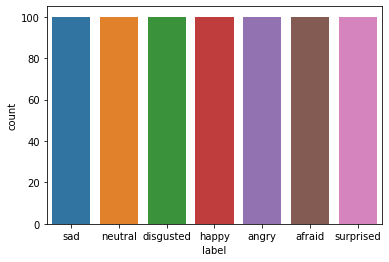

In [ ]:
sns.countplot(train['label'])

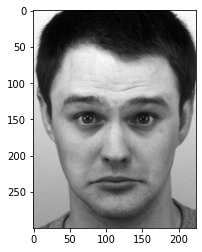

In [ ]:
from PIL import Image

# center crop 적용 후, 224 x 300의 크기를 사용
img = Image.open(train['image'][0]).convert("L")
frac = 0.75
left = img.size[0]*((1-frac)/2)
upper = img.size[1]*((1-frac)/2)
right = img.size[0]-((1-frac)/2)*img.size[0]
bottom = img.size[1]-((1-frac)/2)*img.size[1]

cropped_img = img.crop((left, upper, right, bottom)).resize((224,300), Image.ANTIALIAS)
plt.imshow(cropped_img, cmap='gray');

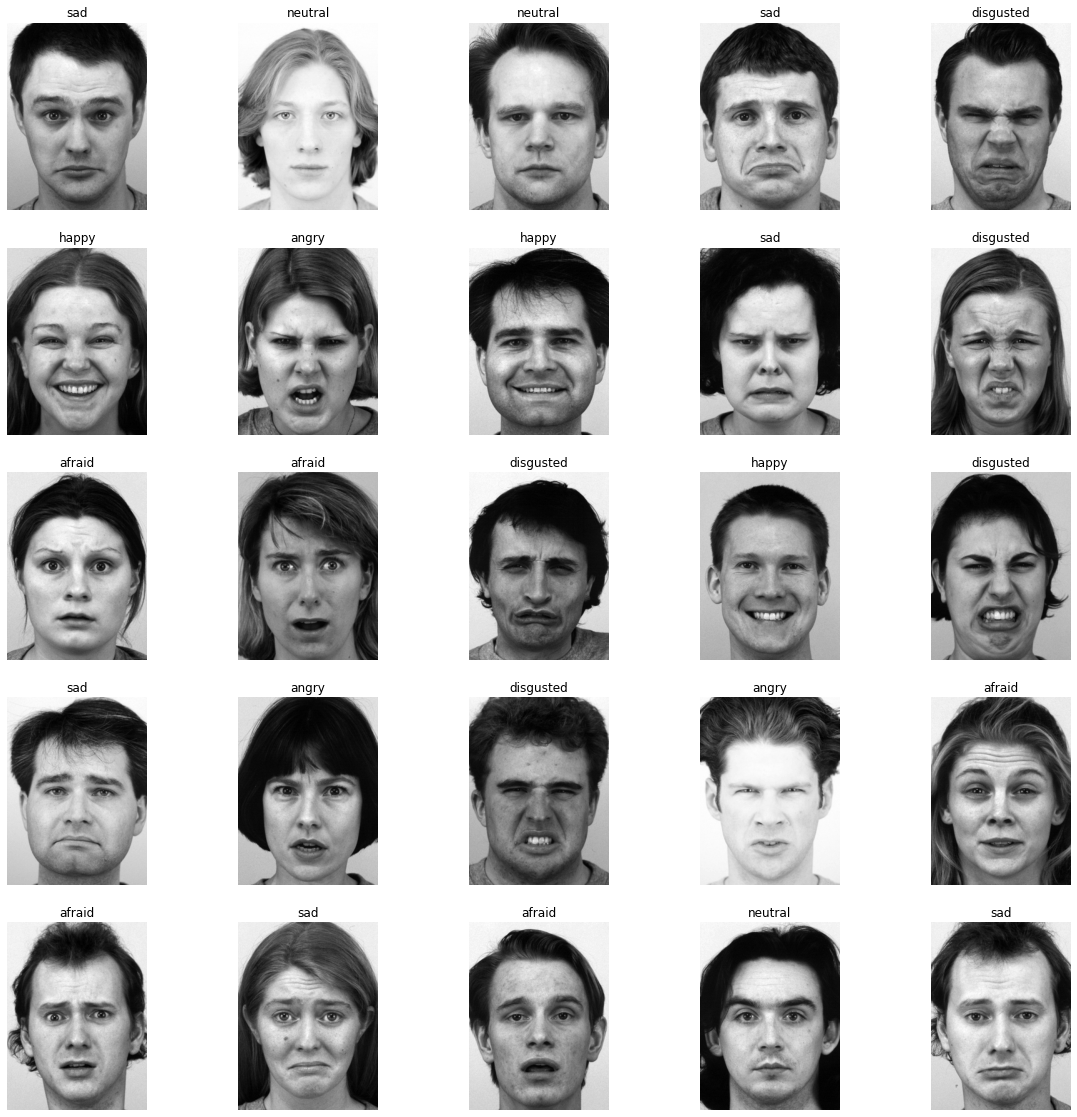

In [ ]:
# to display grid of images
plt.figure(figsize=(20,20))
files = train.iloc[0:25]

for index, file, label in files.itertuples():
    plt.subplot(5, 5, index+1)
    img = load_img(file, grayscale=True)
    cropped_img = img.crop((left, upper, right, bottom)).resize((224,300), Image.ANTIALIAS)
    img = np.array(cropped_img)
    plt.imshow(cropped_img, cmap='gray')
    plt.title(label)
    plt.axis('off')

## Feature Extraction

In [ ]:
train_features = extract_features(train['image'])

  0%|          | 0/700 [00:00<?, ?it/s]

(700, 300, 224, 1)


In [ ]:
test_features = extract_features(test['image'])

  0%|          | 0/1400 [00:00<?, ?it/s]

(1400, 300, 224, 1)


In [ ]:
## normalize the image
x_train = train_features/255.0
x_test = test_features/255.0

In [ ]:
## convert label to integer
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(train['label'])
y_train = le.transform(train['label'])
y_test = le.transform(test['label'])

In [ ]:
# one-hot encoding
y_train = to_categorical(y_train, num_classes=7)
y_test = to_categorical(y_test, num_classes=7)

In [ ]:
print(y_train[0])
print(y_test[0])

[0. 0. 0. 0. 0. 1. 0.]
[1. 0. 0. 0. 0. 0. 0.]


## Model Creation

In [ ]:
# config
input_shape = (300, 224, 1)
output_class = 7

In [ ]:
model = Sequential()
# convolutional layers
model.add(Conv2D(128, kernel_size=(3,3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(256, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(512, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(512, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Flatten())
# fully connected layers
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))

# output layer
model.add(Dense(output_class, activation='softmax'))

opt = tf.keras.optimizers.Adam(learning_rate=0.00001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics='accuracy')

print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 298, 222, 128)     1280      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 149, 111, 128)    0         
 2D)                                                             
                                                                 
 dropout_12 (Dropout)        (None, 149, 111, 128)     0         
                                                                 
 conv2d_9 (Conv2D)           (None, 147, 109, 256)     295168    
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 73, 54, 256)      0         
 2D)                                                             
                                                                 
 dropout_13 (Dropout)        (None, 73, 54, 256)      

In [ ]:
# train the model
history = model.fit(x=x_train, y=y_train, batch_size=32, epochs=100, validation_data=(x_test, y_test))

Epoch 1/100
22/22 [==============================] - 15s 662ms/step - loss: 1.9558 - accuracy: 0.1443 - val_loss: 1.9453 - val_accuracy: 0.1443
Epoch 2/100
22/22 [==============================] - 14s 651ms/step - loss: 1.9497 - accuracy: 0.1386 - val_loss: 1.9452 - val_accuracy: 0.1836
Epoch 3/100
22/22 [==============================] - 14s 659ms/step - loss: 1.9519 - accuracy: 0.1343 - val_loss: 1.9452 - val_accuracy: 0.1771
Epoch 4/100
22/22 [==============================] - 14s 667ms/step - loss: 1.9439 - accuracy: 0.1471 - val_loss: 1.9450 - val_accuracy: 0.1500
Epoch 5/100
22/22 [==============================] - 14s 664ms/step - loss: 1.9434 - accuracy: 0.1629 - val_loss: 1.9449 - val_accuracy: 0.1686
Epoch 6/100
22/22 [==============================] - 14s 658ms/step - loss: 1.9346 - accuracy: 0.1629 - val_loss: 1.9446 - val_accuracy: 0.1857
Epoch 7/100
22/22 [==============================] - 19s 873ms/step - loss: 1.9333 - accuracy: 0.1700 - val_loss: 1.9442 - val_accuracy:

## Plot the Results

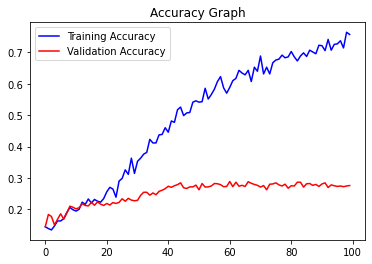

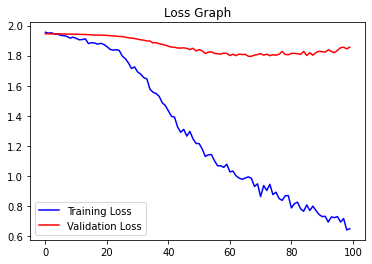

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()

plt.show()

## Save Model

In [ ]:
model.save('fer_straight.h5')

# 👈 👉 Side-View Model 


> 측면 사진만 학습할 모델

---





In [ ]:
TRAIN_DIR = '/content/drive/MyDrive/KDEF_Angle2/Train/side/'

In [ ]:
## convert into dataframe
train = pd.DataFrame()
train['image'], train['label'] = load_dataset(TRAIN_DIR)
# shuffle the dataset
train = train.sample(frac=1).reset_index(drop=True)
train.head()

happy Completed
sad Completed
afraid Completed
surprised Completed
angry Completed
disgusted Completed
neutral Completed
.ipynb_checkpoints Completed


,image,label
0,/content/drive/MyDrive/KDEF_Angle2/Train/side/...,surprised
1,/content/drive/MyDrive/KDEF_Angle2/Train/side/...,disgusted
2,/content/drive/MyDrive/KDEF_Angle2/Train/side/...,sad
3,/content/drive/MyDrive/KDEF_Angle2/Train/side/...,happy
4,/content/drive/MyDrive/KDEF_Angle2/Train/side/...,sad


## Exploratory Data Analysis

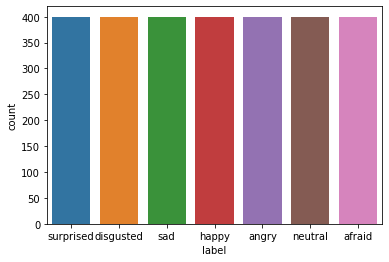

In [ ]:
sns.countplot(train['label'])

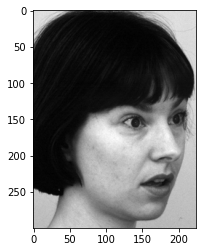

In [ ]:
from PIL import Image

# center crop 적용 후, 224 x 300의 크기를 사용
img = Image.open(train['image'][0]).convert("L")
frac = 0.75
left = img.size[0]*((1-frac)/2)
upper = img.size[1]*((1-frac)/2)
right = img.size[0]-((1-frac)/2)*img.size[0]
bottom = img.size[1]-((1-frac)/2)*img.size[1]

cropped_img = img.crop((left, upper, right, bottom)).resize((224,300), Image.ANTIALIAS)
plt.imshow(cropped_img, cmap='gray');

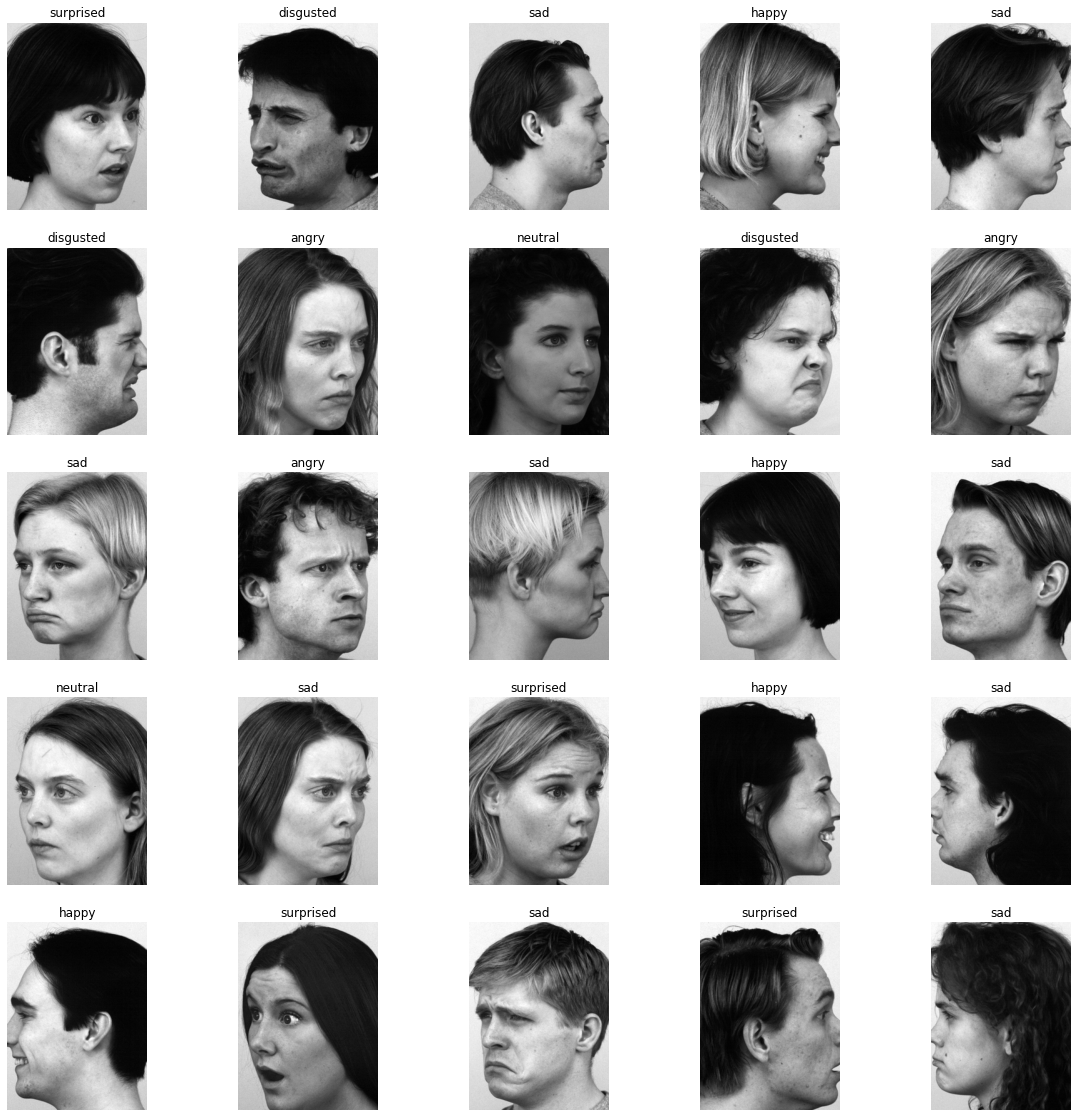

In [ ]:
# to display grid of images
plt.figure(figsize=(20,20))
files = train.iloc[0:25]

for index, file, label in files.itertuples():
    plt.subplot(5, 5, index+1)
    img = load_img(file, grayscale=True)
    cropped_img = img.crop((left, upper, right, bottom)).resize((224,300), Image.ANTIALIAS)
    img = np.array(cropped_img)
    plt.imshow(cropped_img, cmap='gray')
    plt.title(label)
    plt.axis('off')

## Feature Extraction

In [ ]:
train_features = extract_features(train['image'])

  0%|          | 0/2800 [00:00<?, ?it/s]

(2800, 300, 224, 1)


In [ ]:
test_features = extract_features(test['image'])

  0%|          | 0/1400 [00:00<?, ?it/s]

(1400, 300, 224, 1)


In [ ]:
## normalize the image
x_train = train_features/255.0
x_test = test_features/255.0

In [ ]:
## convert label to integer
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(train['label'])
y_train = le.transform(train['label'])
y_test = le.transform(test['label'])

In [ ]:
# one-hot encoding
y_train = to_categorical(y_train, num_classes=7)
y_test = to_categorical(y_test, num_classes=7)

In [ ]:
print(y_train[0])
print(y_test[0])

[0. 0. 0. 0. 0. 0. 1.]
[0. 0. 0. 0. 1. 0. 0.]


## Model Creation

In [ ]:
# config
input_shape = (300, 224, 1)
output_class = 7

In [ ]:
model = Sequential()
# convolutional layers
model.add(Conv2D(128, kernel_size=(3,3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(256, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(512, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(512, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Flatten())
# fully connected layers
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))

# output layer
model.add(Dense(output_class, activation='softmax'))

opt = tf.keras.optimizers.Adam(learning_rate=0.00001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics='accuracy')

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 298, 222, 128)     1280      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 149, 111, 128)    0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 149, 111, 128)     0         
                                                                 
 conv2d_5 (Conv2D)           (None, 147, 109, 256)     295168    
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 73, 54, 256)      0         
 2D)                                                             
                                                                 
 dropout_7 (Dropout)         (None, 73, 54, 256)      

In [ ]:
# train the model
history = model.fit(x=x_train, y=y_train, batch_size=32, epochs=100, validation_data=(x_test, y_test))

Epoch 1/100
88/88 [==============================] - 45s 501ms/step - loss: 1.9522 - accuracy: 0.1546 - val_loss: 1.9449 - val_accuracy: 0.1671
Epoch 2/100
88/88 [==============================] - 41s 472ms/step - loss: 1.9458 - accuracy: 0.1471 - val_loss: 1.9444 - val_accuracy: 0.1879
Epoch 3/100
88/88 [==============================] - 42s 479ms/step - loss: 1.9367 - accuracy: 0.1671 - val_loss: 1.9436 - val_accuracy: 0.1921
Epoch 4/100
88/88 [==============================] - 42s 476ms/step - loss: 1.9317 - accuracy: 0.1782 - val_loss: 1.9426 - val_accuracy: 0.1886
Epoch 5/100
88/88 [==============================] - 42s 477ms/step - loss: 1.9294 - accuracy: 0.1821 - val_loss: 1.9414 - val_accuracy: 0.1964
Epoch 6/100
88/88 [==============================] - 42s 476ms/step - loss: 1.9241 - accuracy: 0.1839 - val_loss: 1.9408 - val_accuracy: 0.2107
Epoch 7/100
88/88 [==============================] - 42s 476ms/step - loss: 1.9213 - accuracy: 0.1829 - val_loss: 1.9399 - val_accuracy:

## Plot the Results

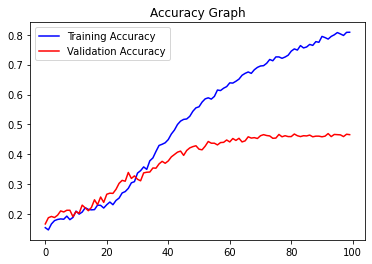

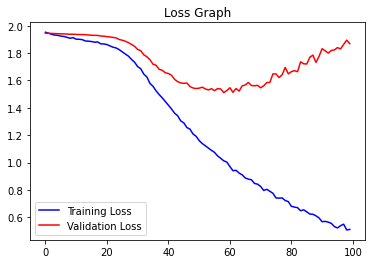

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()

plt.show()

## Save Model

In [ ]:
model.save('fer_side.h5')

# 🏭 Ensemble Model


> 2개의 모델을 앙상블



## Feature Extraction

In [ ]:
test_features = extract_features(test['image'])

  0%|          | 0/1400 [00:00<?, ?it/s]

(1400, 300, 224, 1)


In [ ]:
## normalize the image
x_test = test_features/255.0

In [ ]:
## convert label to integer
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(train['label'])
y_test = le.transform(test['label'])

In [ ]:
print(y_test)

[4 4 4 ... 1 1 1]


## Evaluate Ensemble

In [ ]:
from sklearn.metrics import accuracy_score
from tqdm import tqdm

In [ ]:
model_straight = tf.keras.models.load_model('/content/drive/MyDrive/fer_straight.h5')
model_side = tf.keras.models.load_model('/content/fer_side.h5')

In [ ]:
models = [model_straight, model_side]

In [ ]:
def ensemble_predictions(models, test_x):
    # make predictions
    yhats = [model.predict(test_x, verbose = 0) for model in models]
    yhats = np.array(yhats)
    # sum across ensemble members
    summed = np.sum(yhats, axis=0)
    # argmax across classes
    result = np.argmax(summed, axis=1)
    return result

In [ ]:
def evaluate_ensemble_model(models, test_x, test_y):
    # make prediction
    yhat = [ensemble_predictions(models, testData.reshape(1, 300, 224, 1)) for testData in tqdm(test_x)]
    # calculate accuracy
    return accuracy_score(test_y, yhat)

In [ ]:
score = evaluate_ensemble_model(models, x_test, y_test)

100%|██████████| 1400/1400 [03:02<00:00,  7.65it/s]


In [ ]:
print(f'Accuracy : {score}')

Accuracy : 0.48428571428571426
